# Reading in data and exploring

Reading in libraries I will use.

In [1]:
import pandas as pd
import numpy as np

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Tons of variables. Some are probably binary classifiers. We can plot how many unique values each variable has.

Text(0, 0.5, 'Number of Quant Variables')

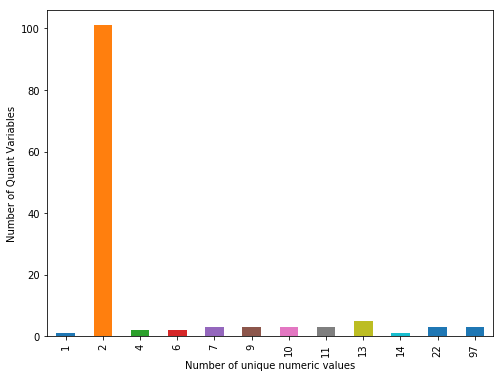

In [3]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(figsize=(8,6))
plt.xlabel('Number of unique numeric values')
plt.ylabel('Number of Quant Variables')

Look at float columns. The mean education definitely appears to have divides between the poverty levels (especially between not non vulnerable and everyone else).

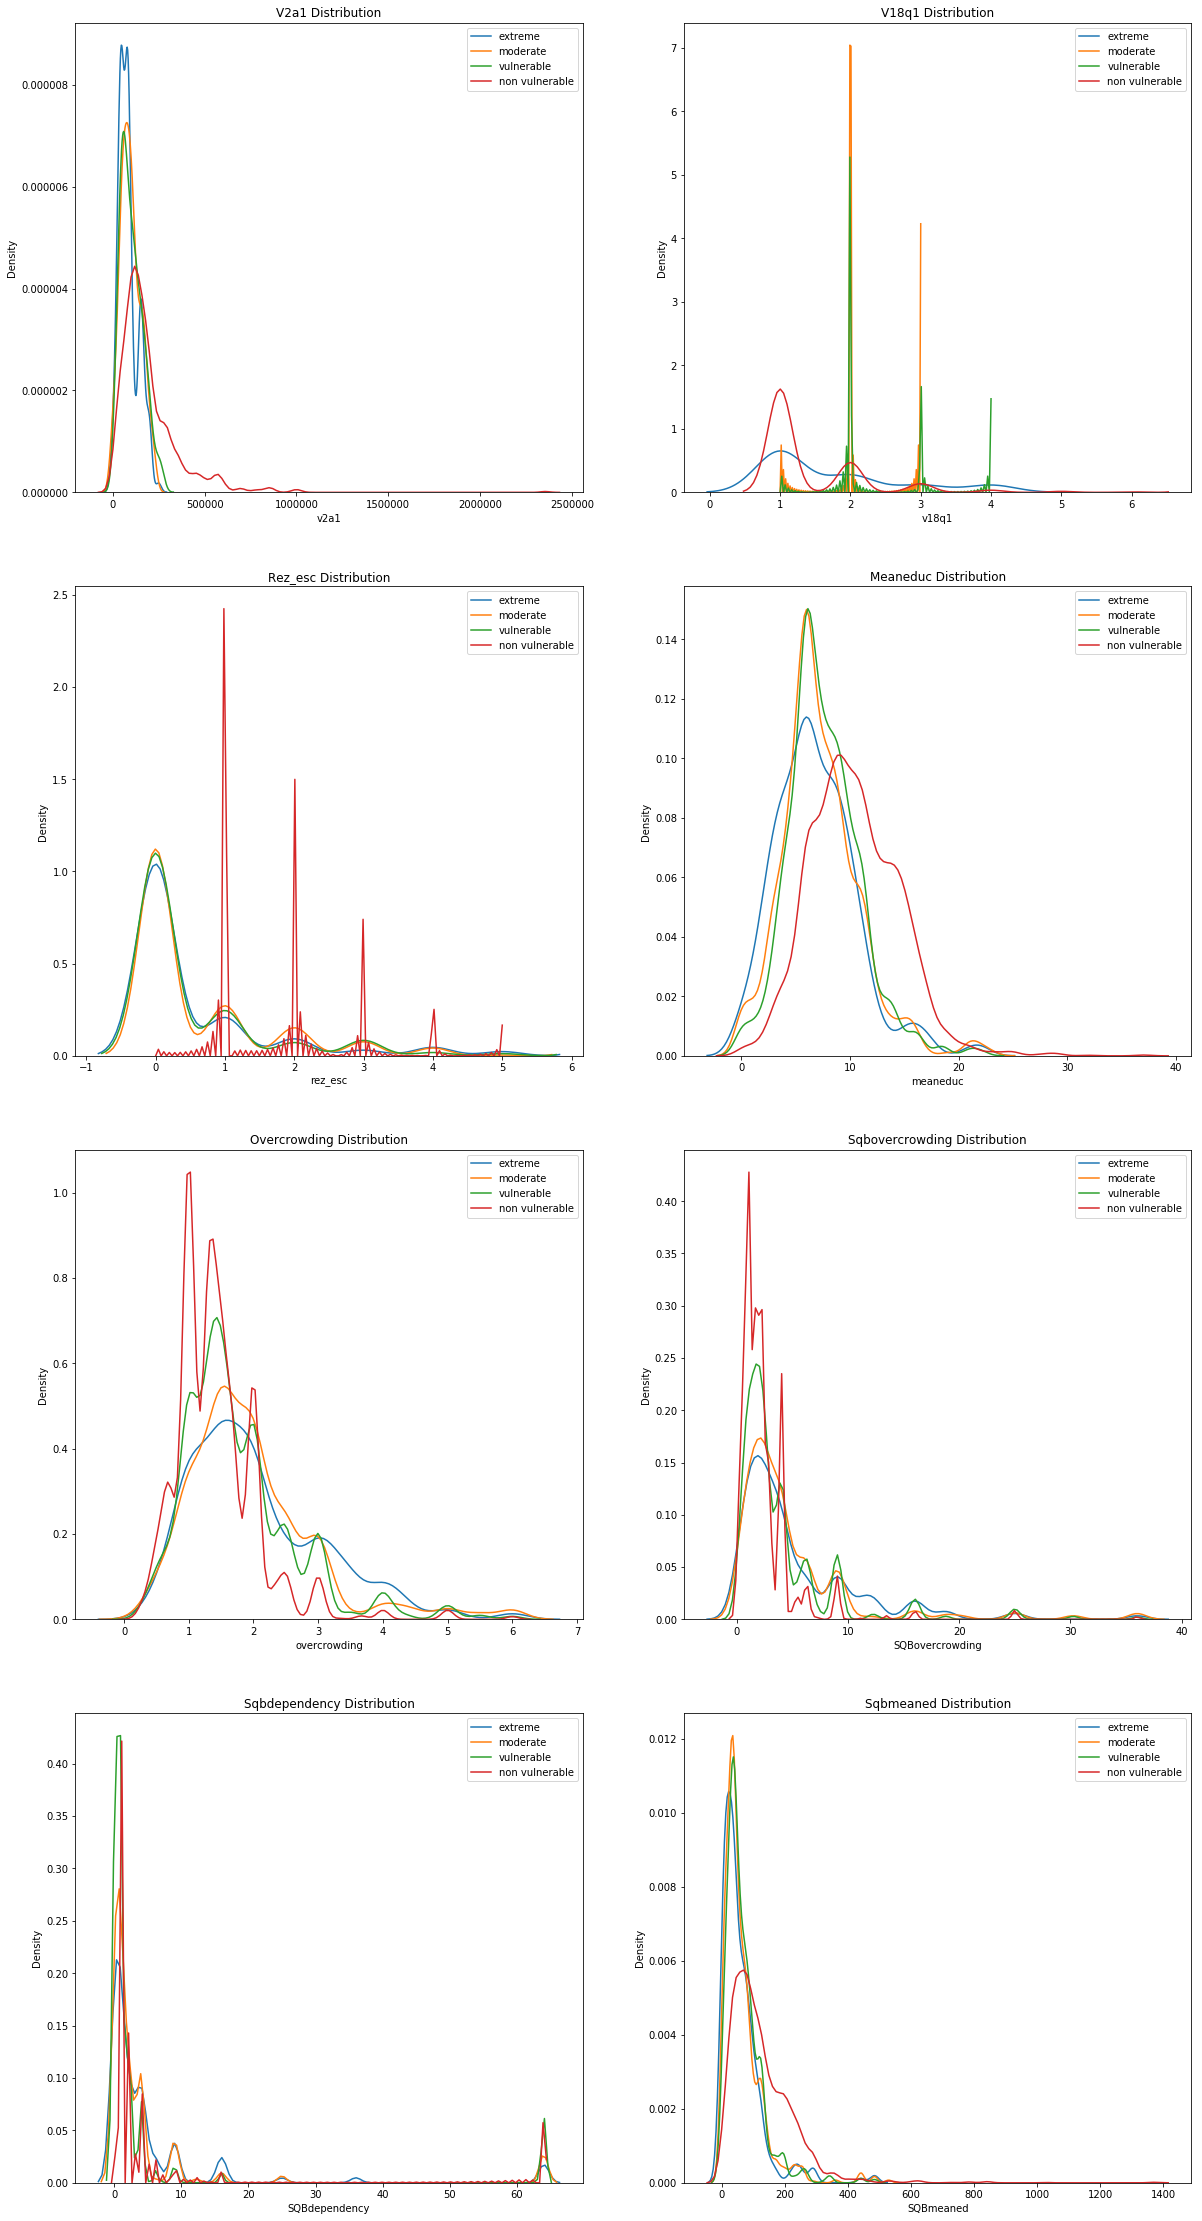

In [4]:
plt.figure(figsize = (20, 16))

colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

for i, var in enumerate(train.select_dtypes(np.float)):
    ax = plt.subplot(4, 2, i + 1)
    for poverty_level, color in colors.items():
        sns.kdeplot(train.loc[train['Target'] == poverty_level, var].dropna(), ax=ax, label = poverty_mapping[poverty_level])
        
    plt.title(f'{var.capitalize()} Distribution'); plt.xlabel(f'{var}'); plt.ylabel('Density')
plt.subplots_adjust(top = 2)

Look at categorical variables. We have ids, dependency, and jefe stuff.

In [5]:
train.select_dtypes(object).head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Noticing how there are 'yes', 'no', and numbers for dependency and jefes. We will replace 'yes' with 1 and 'no' with 0.

I want to edit the features so I will append the test dataset to the training data so I don't have to edit both sets.

In [6]:
test['Target'] = np.nan
data = train.append(test, ignore_index=True)

In [7]:
data['dependency'].replace('yes', 1, inplace=True)
data['dependency'].replace('no', 0, inplace=True)
data['edjefe'].replace('yes', 1, inplace=True)
data['edjefe'].replace('no', 0, inplace=True)
data['edjefa'].replace('yes', 1, inplace=True)
data['edjefa'].replace('no', 0, inplace=True)

data['dependency'] = data['dependency'].astype(np.float)
data['edjefe'] = data['edjefe'].astype(np.float)
data['edjefa'] = data['edjefa'].astype(np.float)

In [8]:
data.select_dtypes(object).head()

,Id,idhogar
0,ID_279628684,21eb7fcc1
1,ID_f29eb3ddd,0e5d7a658
2,ID_68de51c94,2c7317ea8
3,ID_d671db89c,2b58d945f
4,ID_d56d6f5f5,2b58d945f


Fixed it. Now dependency and the jefe variables are numerical.

Since we are making predictions just on the heads of households, I will grab the head entries.

I also want to look and see if the data is balanced on the target variable. It's not.

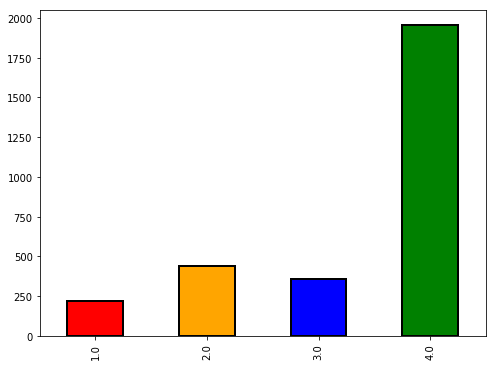

In [9]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), color = colors.values(), edgecolor = 'k', linewidth = 2)

# Missing Data

I want to deal with missing values in the data. I'll look at the 10 variables witht the highest percentage of missing values.

In [10]:
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0: 'total'})
missing['percent'] = missing['total'] / len(data)
missing.sort_values('percent', ascending=False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


v18q1 (number of tablets) is a discrete variable so we can look at a barplots.

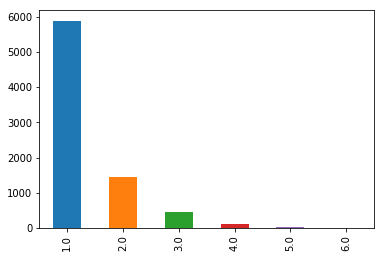

In [11]:
data['v18q1'].value_counts().plot.bar()

I'm assuming that the missing values are 0 since we don't have any 0s and 0 seems like a likely value for number of tablets.

In [12]:
data['v18q1'].fillna(0, inplace=True)

Now looking at rental payments (v2a1). We can use the ownership type variables to try to understand missing values here to see which kinds of ownership have missing values for rental payments.

In [13]:
own_variables = [x for x in data if x.startswith('tipo')]
data.loc[data['v2a1'].isnull(), own_variables].sum()

tipovivi1    20844
tipovivi2        0
tipovivi3        0
tipovivi4      597
tipovivi5     2822
dtype: int64

From the data description, 
tipovivi1=1: own and fully paid house,
tipovivi2=1: own,  paying in installments,
tipovivi3=1: rented,
tipovivi4=1: precarious,
tipovivi5=1: other(assigned,  borrowed)

So most of the missing values are for people who own and fully paid the house off so they should have no rental payments. So we can vill the variable with 0 for those and then impute the missing values of the other types with the median.

In [14]:
data['v2a1'] = data.loc[data['tipovivi1']==1]['v2a1'].fillna(0)

In [15]:
data['v2a1'] = data['v2a1'].fillna((data['v2a1'].median()))

The last variable with lots of missing values is rez_esc (years behind in school). We can look at the ages of people who don't have missing values and those who do.

In [16]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [17]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

Here we see that most people with missing values are adults who have (presumably) finished school. We will assume from the data description that only people between 7 and 19 years of age can have years behind in school. So we will fill people outside this age range with 0.

In [18]:
data.loc[((data['age'] < 7) | (data['age'] > 19)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

We can impute the rest of the missing values with the median.

In [19]:
data['rez_esc'] = data['rez_esc'].fillna((data['rez_esc'].median()))

# Feature Engineering

Now I want to focus on feature engineering. Since we are only predicting for head of households, I want to aggregate individual variables by household using other types of variables.

ID variables

In [20]:
ids = ['Id', 'Target', 'idhogar']

Individual variables

In [21]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 
            'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco1', 'parentesco2',  'parentesco3', 
            'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 
            'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'mobilephone']

ind_ordered = ['escolari', 'rez_esc', 'age']

ind = data[ids + ind_bool + ind_ordered]

Household variables

In [22]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 'paredpreb','pisocemento', 'pareddes', 
           'paredmad','paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 'pisonatur', 'pisonotiene', 
           'pisomadera','techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 
           'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 'sanitario2', 
           'sanitario3', 'sanitario5',   'sanitario6','energcocinar1', 'energcocinar2', 'energcocinar3', 
           'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 
           'epared2', 'epared3','etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'tipovivi1', 'tipovivi2', 
           'tipovivi3', 'tipovivi4', 'tipovivi5', 'computer', 'television', 'lugar1', 'lugar2', 'lugar3','lugar4', 
           'lugar5', 'lugar6', 'area1', 'area2']

hh_ordered = ['rooms', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'tamhog', 
             'tamviv', 'hhsize', 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total', 'bedrooms', 'qmobilephone'] 

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

Squared Variables

In [23]:
sqr = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 
      'SQBmeaned', 'agesq']

Checking to see I didn't miss any variables.

In [24]:
len(ids + ind_bool + ind_ordered + hh_bool + hh_ordered + hh_cont + sqr) - data.shape[1]

0

All good.

The squared variables are highly correlated with each of the variables they are squaring so I will remove them.

In [25]:
data.drop(sqr, axis=1, inplace=True)

# Household Variables

In [26]:
heads = data.loc[data['parentesco1'] == 1]
heads = heads[ids + hh_bool + hh_ordered + hh_cont]
heads.head()

,Id,Target,idhogar,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,hogar_mayor,hogar_total,bedrooms,qmobilephone,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding
0,ID_279628684,4.0,21eb7fcc1,0,0,1,1,1,0,0,...,0,1,1,1,0.0,0.0,10.0,0.0,10.0,1.000000
1,ID_f29eb3ddd,4.0,0e5d7a658,0,0,1,1,0,0,0,...,1,1,1,1,0.0,8.0,12.0,0.0,12.0,1.000000
2,ID_68de51c94,4.0,2c7317ea8,0,0,1,1,0,0,0,...,1,1,2,0,0.0,8.0,0.0,11.0,11.0,0.500000
5,ID_ec05b1a7b,4.0,2b58d945f,0,0,1,1,1,0,0,...,0,4,3,3,0.0,1.0,11.0,0.0,11.0,1.333333
8,ID_1284f8aad,4.0,d6dae86b7,1,0,1,1,1,0,0,...,0,4,1,1,0.0,1.0,9.0,0.0,10.0,4.000000


I want to remove some redundant household variables. I can create a correlation matrix. Just want the upper triangle of the matrix (since the bottom triangle gives the same info). Also only interested in correlations above a certain value (.95 for now). 

In [27]:
cor_mat = heads.corr()
upper = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

These variables are correlated with at least one other variable. To find the variables they're correlated with, I'll use the correlation matrix. Start with tamhog

In [28]:
cor_mat.loc[cor_mat['tamhog'].abs() > 0.9, cor_mat['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


Make a heatmap for variables correlated with tamhog

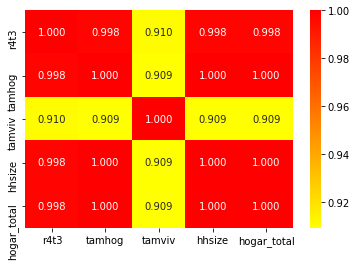

In [29]:
sns.heatmap(cor_mat.loc[cor_mat['tamhog'].abs() > 0.9, cor_mat['tamhog'].abs() > 0.9], annot=True, 
            cmap = plt.cm.autumn_r, fmt='.3f')

Tamhog is perfectly correlated with hhsize and hogar_total and almost perfectly correlated with r4t3. Tamviv is slightly less correlated but still pretty related.

I will drop tamhog, r4t3 and hogar_total, leaving hhsize to give the same information as them. I am also keeping tamviv since it looks like it gives us slightly different information.

In [30]:
heads.drop(['r4t3', 'tamhog', 'hogar_total'], axis=1, inplace=True)

I can create a new variable for the difference between the number of people living in the house, not in the family

In [31]:
heads['hhsize_diff'] = heads['tamviv'] - heads['hhsize']

The next redundant variable is coopele

In [32]:
cor_mat.loc[cor_mat['coopele'].abs() > 0.9, cor_mat['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


These are both indicator variables for electricity. I will turn these (with the other electricity variables) into an ordinal variable

In [33]:
elec = []

for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
heads['elec'] = elec
heads['elec_missing'] = heads['elec'].isnull()

heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

The last redundant variable is area2

In [34]:
cor_mat.loc[cor_mat['area2'].abs() > 0.9, cor_mat['area2'].abs() > 0.9]

,area1,area2
area1,1.0,-1.0
area2,-1.0,1.0


This is perfectly negatively correlated with area1 so I will drop area2

In [35]:
heads = heads.drop(columns = 'area2')

Now all the highly correlated variables are dealt with

I want to create some more ordinal variables based on quality of roof, floor, etc. Bad will be 0, regular is 1, and good is 2

In [36]:
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),axis = 1)

heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]), axis = 1)

heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]), axis = 1)

Feature Engineering. I can create a sum total of quality for walls, roof, and floor together

In [37]:
heads['walls_roof_floor'] = heads['walls'] + heads['roof'] + heads['floor']

I want to create a variable that indicates if a house is in really bad shape, looking at if it is missing basic house necessities.

In [38]:
heads['warning'] = 1 * (heads['sanitario1'] + (heads['elec'] == 0) + heads['pisonotiene'] + 
                        heads['abastaguano'] + (heads['cielorazo'] == 0))

I can check if this actually is a useful variable with a violin plot

Text(0.5, 1.0, 'Target vs. Warning Violinplot')

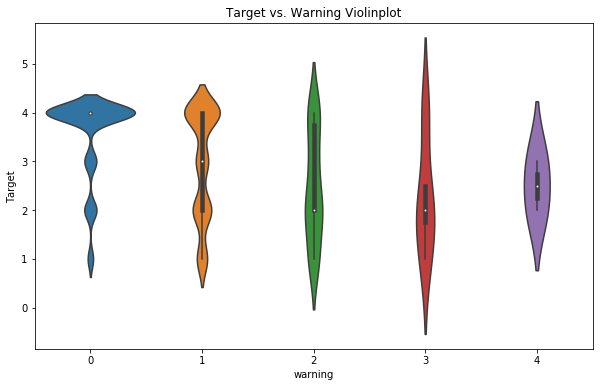

In [39]:
plt.figure(figsize = (10,6))
sns.violinplot(x='warning', y='Target', data=heads)
plt.title('Target vs. Warning Violinplot')

Here we can see that if there are no warnings, it is likely a rich household but as the warnings increase, so do the weights for the lower income houses. So this looks like a good variable to keep

I also want to add a bonus variable for houses that have "luxury" items like a refrigerator, television, tablet, or computer

In [40]:
heads['bonus'] = 1 * (heads['refrig'] + heads['computer'] + (heads['v18q1'] > 0) + heads['television'])

I can also make a violinplot of this variable to see if it looks significant.

Text(0.5, 1.0, 'Target vs. Bonus Violinplot')

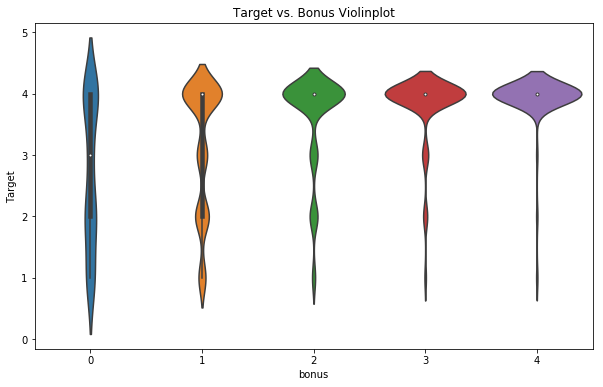

In [41]:
plt.figure(figsize = (10,6))
sns.violinplot(x='bonus', y='Target', data=heads)
plt.title('Target vs. Bonus Violinplot')

This one shows the opposite of the previous in that as the bonus variable increases, the weights on the lower income houses decrease.

I also want to look at per capita features since there could be more mobile phones in one house but this could simply be many people sharing

In [42]:
heads['phones_per_capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets_per_capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms_per_capita'] = heads['rooms'] / heads['tamviv']
heads['rent_per_capita'] = heads['v2a1'] / heads['tamviv']

# Individual variables

I want to look for highly correlated variables like I did for the household variables.

In [43]:
cor_mat = ind.corr()
upper = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
to_drop

['female']

There is only one. Female is perfectly correlated with male so I will drop male.

In [44]:
ind = ind.drop('male', axis=1)

Now I want to create ordinal variables from bools like I did with household variables

I will start with the number of years of education variables.

In [45]:
ind['inst'] = np.argmax(np.array(ind[[x for x in ind if x.startswith('instl')]]), axis=1)

I will drop the boolean education varibles now

In [46]:
ind = ind.drop(columns = [x for x in ind if x.startswith('instl')])

I will divide the education variables by age to standardize

In [47]:
ind['inst_age'] = ind['inst'] / ind['age']
ind['escolari_age'] = ind['escolari'] / ind['age']

I also want to find the number of tablets/phones each individual has

In [48]:
ind['tech'] = ind['v18q'] + ind['mobilephone']

Now I want to create household variables using individual variables.

Define range function as another aggregate statistic to use for individual variables

In [49]:
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

Aggregation for individual variables

In [50]:
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...    \
           min max sum count  std range_ min max sum count  ...     
idhogar                                                     ...     
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...     
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...     
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...     
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...     
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...     

          escolari_age                           tech                     \
                   sum count       std    range_  min max sum count  std   
idhogar                                                                    
000a08204     0.900000     3  0.264575  0.500000    2   2   6     3  0.0   
000bce7c4     0.083333     2  0.058926  0.083333    1   1   2     2  0.0   
001845fb0     1.397906     4  0.183106  0.410931    1   1   4     4  0.0   
001ff74ca     0.421053     1       NaN  0.000000    2   2   4     2  0.0   
003123ec2     0.554348     4  0.161557  0.304348    1   1   4     4  0.0   

                  
          range_  
idhogar           
000a08204      0  
000bce7c4      0  
001845fb0      0  
001ff74ca      0  
003123ec2      0  

[5 rows x 180 columns]

I can use the min, max, sum, count, standard deviation, and range for each household (using individual data) as a household feature

Renaming the columns so that the feature name is with the aggregate statistic

In [51]:
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}_{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q_min,v18q_max,v18q_sum,v18q_count,v18q_std,v18q_range_,dis_min,dis_max,dis_sum,dis_count,...,escolari_age_sum,escolari_age_count,escolari_age_std,escolari_age_range_,tech_min,tech_max,tech_sum,tech_count,tech_std,tech_range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.900000,3,0.264575,0.500000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.083333,2,0.058926,0.083333,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,1.397906,4,0.183106,0.410931,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.421053,1,NaN,0.000000,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.554348,4,0.161557,0.304348,1,1,4,4,0.0,0


These aggregate variables are likely highly correlated so I can remove the correlated ones.

In [52]:
corr_matrix = ind_agg.corr()

#Upper tirangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

In [53]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 198)


Adding these aggregate features to the original household features gives 198 features

Check out the most correlated variables with the target

In [54]:
corrs = final.corr()['Target']

In [55]:
corrs.sort_values().head()

warning            -0.301791
hogar_nin          -0.266309
r4t1               -0.260917
estadocivil1_sum   -0.239130
overcrowding       -0.234954
Name: Target, dtype: float64

In [56]:
corrs.sort_values().dropna().tail()

walls_roof_floor    0.332446
meaneduc            0.333652
inst_max            0.368229
escolari_max        0.373091
Target              1.000000
Name: Target, dtype: float64

It would also be interesting to consider the gender, age, and years of schooling for the head of household

In [57]:
head_demo = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female', 'escolari', 'age']]
final = final.merge(head_demo, on='idhogar', how='left').rename(columns = {'female': 'female_head',
                                                                          'escolari': 'escolari_head',
                                                                          'age': 'age_head'})
final.head()

,Id,Target,idhogar,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari_age_max,escolari_age_std,escolari_age_range_,tech_min,tech_sum,tech_std,tech_range_,female_head,escolari_head,age_head
0,ID_279628684,4.0,21eb7fcc1,0,0,1,1,1,0,0,...,0.232558,NaN,0.000000,1,1,NaN,0,0,10,43
1,ID_f29eb3ddd,4.0,0e5d7a658,0,0,1,1,0,0,0,...,0.179104,NaN,0.000000,2,2,NaN,0,0,12,67
2,ID_68de51c94,4.0,2c7317ea8,0,0,1,1,0,0,0,...,0.119565,NaN,0.000000,0,0,NaN,0,1,11,92
3,ID_ec05b1a7b,4.0,2b58d945f,0,0,1,1,1,0,0,...,0.529412,0.126943,0.279412,2,8,0.0,0,0,11,38
4,ID_1284f8aad,4.0,d6dae86b7,1,0,1,1,1,0,0,...,0.392857,0.168946,0.392857,1,4,0.0,0,0,9,30


## Modelling

Loading modelling libraries...

In [58]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')

Get the training labels and split back into training and testing set

In [59]:
train_labs = np.array(final[final['Target'].notnull()]['Target']).astype(np.uint8)

train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'Target', 'idhogar'])

test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'Target', 'idhogar'])

The data still has some missing data and is not scaled so I need to fix that before modelling

In [60]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_data = train_set
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

Get the train and test split that I will use in my models.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(train_set, train_labs)

I want to do preliminary checks on how well different classification models do on the data. I will use cross validation scoring.

In [62]:
# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [63]:
def test_clf(clf):
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    print(clf.__class__.__name__)
    print(classification_report(y_test, y_pred_test))

The 5 classification models I want to check are K-Nearest Neighobrs, Naive-Bayes, Support Vector Machine, Random Forest, and Gradient Boosting.

In [64]:
knn = KNeighborsClassifier()
nb = GaussianNB()
svc = SVC()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

models = [knn, nb, svc, rf, gb]

for clf in models:
    test_clf(clf)

KNeighborsClassifier
             precision    recall  f1-score   support

          1       0.24      0.14      0.18        57
          2       0.38      0.25      0.30       122
          3       0.21      0.12      0.15        89
          4       0.72      0.87      0.78       476

avg / total       0.56      0.62      0.58       744

GaussianNB
             precision    recall  f1-score   support

          1       0.21      0.18      0.19        57
          2       0.50      0.03      0.06       122
          3       0.12      0.87      0.21        89
          4       0.96      0.11      0.20       476

avg / total       0.73      0.19      0.18       744

SVC
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        57
          2       0.00      0.00      0.00       122
          3       0.00      0.00      0.00        89
          4       0.64      1.00      0.78       476

avg / total       0.41      0.64      0.50       744

R

The three best models are Random Forest, K-Nearest Neighbors, and Gradient Boosting. I'll try and tune each of these models and see if I can optimize performance.

# Evaluation

I will use train/test split to evaluate all of my models, using the same split between each model. I will also report the test F1 and accuracy. I am using macro scores for each evaluation metric so that the score for each class is weighted equally. I am particularly interested in how accurately the model can correctly predict for the lower income classes because we are trying to identify people who need aid. Recall will be an important metric for looking at how well the model predicts the lower classes. Since the classes are very unbalanced (there are many more observations for the upper class), I will have to ensure that that class is not too heavily favored in some models.

# K-Nearest Neighbors

I am trying the K-Nearest Neighbors because I think that we can use train households with similar data to predict on the test households.

I tried out different hyperparameters for the number of neighbors. I used 3, 5, and 7 at first and found that 5 was the best so I then ran it with 4, 5, and 6 for the number of neighbors.

In [65]:
clf = KNeighborsClassifier()
# gridsearch = GridSearchCV(clf, {"n_neighbors": [3, 5, 7], "weights": ['uniform', 'distance'], 
#                                 'p': [1, 2, 3]}, scoring=scorer)
gridsearch = GridSearchCV(clf, {"n_neighbors": [4, 5, 6], "weights": ['uniform', 'distance'], 
                                'p': [1, 2]}, scoring=scorer, n_jobs=-1)
gridsearch.fit(X_train, y_train)

print("Best Params: {}".format(gridsearch.best_params_))
print("Test Classification Report:")

y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)

print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Test Classification Report:
             precision    recall  f1-score   support

          1       0.30      0.14      0.19        57
          2       0.36      0.25      0.29       122
          3       0.12      0.08      0.10        89
          4       0.73      0.88      0.80       476

avg / total       0.56      0.62      0.58       744

Train Accuracy: 0.7424854194706146	Test accuracy: 0.6236559139784946


The F1 score is .58 and the accuracy is .63 for the test data. The F1 score is really high for the wealthiest class. The F1 score for class 3 (2nd wealthiest) is really low but I do not think that is that big an issue because that group probably would not be entitled to that much aid. What is concerning is the low F1 scores for classes 1 and 2 because those are the ones that probably require aid. The recall for these classes is lower than precision while the precision is lower than recall for classes 3 and 4, indicating that we are misclassifying a lot of class 1 and class 2 households as class 3 and 4. This makes sense since we have more data for classes 3 and 4, but it is still an issue. There is a difference between the train and test accuracy but it's not so huge that I would worry about dealing with overfitting unless I later decide that this is the best model.

# Random Forest

Trying different hyperparameters. I'm tuning as I go, adjusting the number of estimators, and the max depth of the trees.

Edit: I have also included max_features as a hyperparameter that I want to tune because of overfitting.

In [80]:
#n_estimators = [100, 500, 1000]
n_estimators = [800, 1000, 1200]
#n_estimators = [650, 750, 850]
#n_estimators = [800, 850, 900]
#max_depth = [1, 8, 15]
#max_depth = [5, 8, 10]
max_depth = [9, 10, 12]
#max_features = [25, 50, 100]
#max_features = [20, 25, 30]
max_features = [15, 20, 23]
#class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for max_feats in max_features:
            clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, 
                                        max_features = max_feats, class_weight='balanced')
            clf.fit(X_train, y_train)
            f1 = f1_score(y_train, np.argmax(clf.oob_decision_function_ , 1), average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, max_feats, wgt)


print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.11569938410707774
Best params: (800, 9, 20, 'balanced')


Now that I've tuned the model and found the best parameters, I can run the model and see how well it performs.

In [81]:
clf = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], max_features = best_params[2], 
                             class_weight=best_params[3])
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.36      0.25      0.29        57
          2       0.33      0.43      0.37       122
          3       0.26      0.30      0.28        89
          4       0.82      0.76      0.79       476

avg / total       0.64      0.61      0.62       744

Train Accuracy: 0.9057873485868102	Test accuracy: 0.614247311827957


I found an increase in the F1 score from the baseline Random Forest model after tuning hyperparameters. What is specifically nice to see is that the F1 scores for the lower two classes are relatively high compared to the baseline Random Forest model and the tuned K-Nearest Neighbors model. What is concerning, however, is that the train accuracy is so much higher than the test accuracy. This indicates overfitting. I can work on dropping less important features in order to deal with it.

In the model, I tuned the maximum number of features hyperparameter and found that a lower number performed the best. This increased the F1 score.

I want to look at the most important features on predicting the poverty class for households using the random forest model. I will look at the first 20 since those are the ones used in the tuned model.

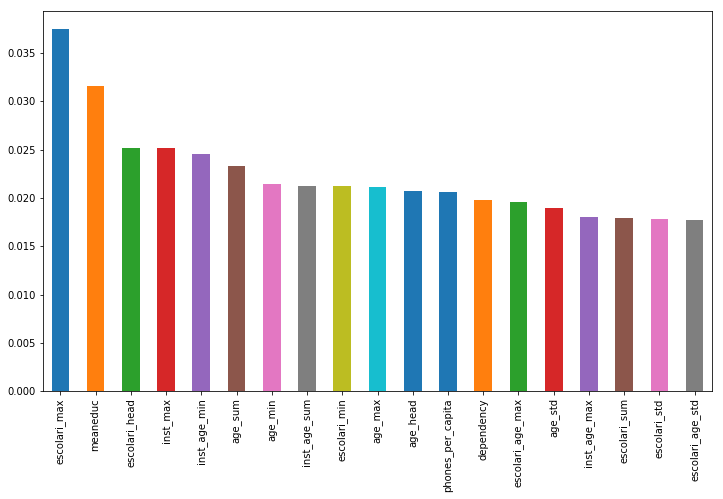

In [85]:
feature_imp = sorted(list(zip(train_data.columns, clf.feature_importances_)), key=lambda x: x[1], reverse=True)[0:19]
plt.figure(figsize = (12,7))
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

The two most important features are escolari_max which tells the maximum years of schooling completed by any member of the household and meaneduc which gives the average years of education for adults in the household. There is a big dropoff in feature importances after these two. The next four have about the same importance before another big dropoff. They are the years of education for the head of household, the highest level of education acquired (elementary, secondary, etc.), the minimum ratio of level of education to age, and the sum of the ages.

## Gradient Boosting

Tuning hyperparameters. This model takes a long time so I probably won't do too much tuning.

In [90]:
clf = GradientBoostingClassifier()
gridsearch = GridSearchCV(clf, {"n_estimators": [100, 1000], 'max_depth': [1, 3]}, scoring=scorer)
gridsearch.fit(X_train, y_train)

y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.32      0.14      0.20        57
          2       0.36      0.29      0.32       122
          3       0.26      0.19      0.22        89
          4       0.76      0.88      0.81       476

avg / total       0.60      0.65      0.61       744

Train Accuracy: 1.0	Test accuracy: 0.6451612903225806


The gradient boosted model improved in recall and test accuracy but did worse in precision and F1. It's recall, however, was not as good for the lower classes, which are of more interest to us.

## Conclusion

I found that the most important features in estimating poverty relate to the amount of education achieved. This makes intuitive sense as people with more education are more likely to have higher-paying jobs. Other important features relate to the ages of the members of the household. This also makes sense as there are certain ages that are more likely to work and generate income. The only feature of importance that did not fall under these categories was the number of phones per capita in the household. Something interesting to note is that no features about the house were valued as very important by the Random Forest model. This indicates that information about individuals is more inidicative about poverty status than information about the houses they live in.

The Random Forest and Gradient Boosted models performed the best. Since we are primarily interested in trying to identify households that are in need of aid (lower class houses), we are interested in maximizing the recall for the lower classes. While the Gradient Boosted model performed better overall in some metrics, the Random Forest model achieved higher recall for the two lower classes, meaning that it avoided misclassifying the lower classes as higher class households. Another reason why the Random Forest model would be preferred for this problem is because of how much faster it ran than the Gradient Boosted model. There was not a significant increase in performance for the Gradient Boosted model so the extra time to run was not worth it.